In [48]:
import yfinance as yf
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, LayerNormalization, MultiHeadAttention, Dropout, GlobalAveragePooling1D
from sklearn.metrics import mean_squared_error
import math
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model

print('Tensorflow version: {}'.format(tf.__version__))

Tensorflow version: 2.16.1


#### Use for test

In [49]:
stock = '2330'
today = pd.to_datetime('today').strftime('%Y-%m-%d')
fifty_days_before = (pd.to_datetime('today') - pd.DateOffset(days=50)).strftime('%Y-%m-%d')

stock_data = yf.download(f'{stock}.TW', start=fifty_days_before, end=today)
stock_data = stock_data.reset_index()
stock_data = stock_data[['Date', 'Close']] # , 'Volume', 'High', 'Low', 'Open'
stock_data.columns = ['date', 'close'] # , 'volume', 'high', 'low', 'open'
stock_data['ticker'] = stock  # 添加一列來標識股票
# print(stock_data.head())
# 標準化數據
scaler = MinMaxScaler(feature_range=(0, 1))
data = stock_data[['close']].values # 'volume', 'open', 'high', 'low', 
data_scaled = scaler.fit_transform(data)

# 將數據轉換為序列數據
# fetch the lastest 30 days data
seq_data = []
latest_30_data = data_scaled[-30:]
seq_data.append(latest_30_data)
seq_data = np.array(seq_data)
seq_data = seq_data.reshape(seq_data.shape[0], seq_data.shape[1], seq_data.shape[2])
print('seq_data shape: {}'.format(seq_data.shape))

# Load the model
# model = load_model(f'{stock}_model.keras')
model = load_model(f'{stock}_model.keras')

# Predict the future trend
prediction = model.predict(seq_data)
prediction = scaler.inverse_transform(prediction)
print(f'{stock} future trend prediction: {prediction[0][0]}')

[*********************100%%**********************]  1 of 1 completed

seq_data shape: (1, 30, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
2330 future trend prediction: 811.7457885742188


### Fetch target stock price history data

In [30]:
# 抓取台積電的歷史股價資料
stock = '2330.TW'
stock_data = yf.download(stock, start='2010-01-01', end='2024-05-31')
stock_data = stock_data.reset_index()
stock_data = stock_data[['Date', 'High', 'Low', 'Open', 'Close']] # , 'Volume'
stock_data.columns = ['date', 'high', 'low', 'open', 'close'] # , 'volume'
stock_data['ticker'] = stock  # 添加一列來標識股票
print(stock_data.head())

[*********************100%%**********************]  1 of 1 completed

        date       high        low       open      close   ticker
0 2010-01-04  65.000000  64.000000  65.000000  64.900002  2330.TW
1 2010-01-05  65.099998  63.900002  65.000000  64.500000  2330.TW
2 2010-01-06  64.900002  63.700001  64.500000  64.900002  2330.TW
3 2010-01-07  65.000000  64.199997  64.900002  64.199997  2330.TW
4 2010-01-08  64.300003  63.500000  63.500000  64.000000  2330.TW


### Data preprocessing
split the dataset into training set(for fine-tuned) and testing set by the ratio 8:2

In [32]:
# 標準化數據
scaler = MinMaxScaler(feature_range=(0, 1))
data = stock_data[['open', 'high', 'low', 'close']].values # 'volume', 
data_scaled = scaler.fit_transform(data)

# 創建數據集
def create_single_stock_dataset(data_scaled, time_step=30):
    dataX, dataY = [], []
    for i in range(len(data_scaled) - time_step - 1):
        a = data_scaled[i:(i + time_step), :]
        dataX.append(a)
        dataY.append(data_scaled[i + time_step, -1])  # 使用'close'作為目標變量
    return np.array(dataX), np.array(dataY)

# 參數
time_step = 30
x_stock, y_stock = create_single_stock_dataset(data_scaled, time_step)

# 調整輸入形狀以符合模型需求
x_stock = x_stock.reshape(x_stock.shape[0], x_stock.shape[1], x_stock.shape[2])

# 劃分訓練集和測試集
train_size = int(len(x_stock) * 0.8)
val_size = int(len(x_stock) * 0.1)
x_stock_train, x_stock_val, x_stock_test = x_stock[:train_size], x_stock[train_size:train_size+val_size], x_stock[train_size+val_size:]
y_stock_train, y_stock_val, y_stock_test = y_stock[:train_size], y_stock[train_size:train_size+val_size], y_stock[train_size+val_size:]
# x_stock_train, x_stock_test = x_stock[:train_size], x_stock[train_size:]
# y_stock_train, y_stock_test = y_stock[:train_size], y_stock[train_size:]

print('x_stock_train shape: {}'.format(x_stock_train.shape))
print('y_stock_train shape: {}'.format(y_stock_train.shape))
print('x_stock_val shape: {}'.format(x_stock_val.shape))
print('y_stock_val shape: {}'.format(y_stock_val.shape))
print('x_stock_test shape: {}'.format(x_stock_test.shape))
print('y_stock_test shape: {}'.format(y_stock_test.shape))

x_stock_train shape: (2796, 30, 4)
y_stock_train shape: (2796,)
x_stock_val shape: (349, 30, 4)
y_stock_val shape: (349,)
x_stock_test shape: (350, 30, 4)
y_stock_test shape: (350,)


### Load pre-trained model

In [33]:
pretrained_model = load_model('10_stocks_pretrained_model.keras')


### Model's performance before fine-tuned

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Pretrained RMSE: 57.795011023031186


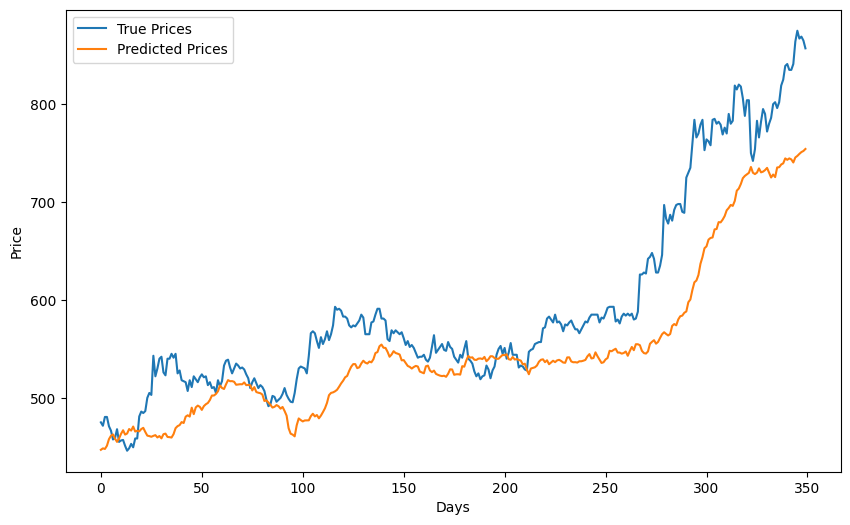

In [34]:
# 微調前的模型預測表現
predicted_stock_prices = pretrained_model.predict(x_stock_test)

# 反標準化預測值
def inverse_transform(scaler, data, original_shape):
    result = []
    for i in range(len(data)):
        scaled_data = np.concatenate([np.zeros((1, original_shape - 1)), data[i].reshape(1, -1)], axis=1)
        result.append(scaler.inverse_transform(scaled_data)[0, -1])
    return np.array(result)

predicted_stock_prices = inverse_transform(scaler, predicted_stock_prices, original_shape=x_stock.shape[2])
y_stock_test_true = inverse_transform(scaler, y_stock_test.reshape(-1, 1), original_shape=x_stock.shape[2])

# 計算微調後的RMSE
fine_tune_rmse = math.sqrt(mean_squared_error(y_stock_test_true, predicted_stock_prices))

print(f"Pretrained RMSE: {fine_tune_rmse}")

# 畫出預測結果
plt.figure(figsize=(10, 6))
plt.plot(y_stock_test_true, label='True Prices')
plt.plot(predicted_stock_prices, label='Predicted Prices')
plt.xlabel('Days')
plt.ylabel('Price')
plt.legend()
plt.show()


### Fine-tuned stage

In [37]:
fine_tune_model = load_model('10_stocks_pretrained_model.keras')

# 微調模型
fine_tune_model.compile(optimizer='adam', loss='mean_squared_error')

# 使用台積電的訓練數據進行微調
# fine_tune_history = fine_tune_model.fit(x_stock_train, y_stock_train, epochs=20, batch_size=32, validation_split=0.2, verbose=1)
from keras.callbacks import EarlyStopping


fine_tune_history = fine_tune_model.fit(x_stock_train, y_stock_train,
                    batch_size=64,
                    epochs=200,
                    validation_data=(x_stock_val, y_stock_val),
                    callbacks=[EarlyStopping(patience=20, restore_best_weights=True)])

Epoch 1/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 4.5311e-04 - val_loss: 0.0031
Epoch 2/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 2.2490e-04 - val_loss: 0.0027
Epoch 3/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 2.1940e-04 - val_loss: 0.0021
Epoch 4/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 1.7089e-04 - val_loss: 0.0029
Epoch 5/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.8406e-04 - val_loss: 0.0038
Epoch 6/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 2.0941e-04 - val_loss: 0.0032
Epoch 7/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 2.1588e-04 - val_loss: 0.0035
Epoch 8/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.8171e-04 - val_loss: 0.0029
Epoch 9/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 1.7733e-04 - val_loss: 0.0026
Epoch 10/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.7910e-04 - val_loss: 0.0024
Epoch 11/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 2.1984e-04 - val_loss: 0.0024
Epoch 12/2

### Model's performance after fine-tuned

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Fine-tuned RMSE: 58.96887720058328


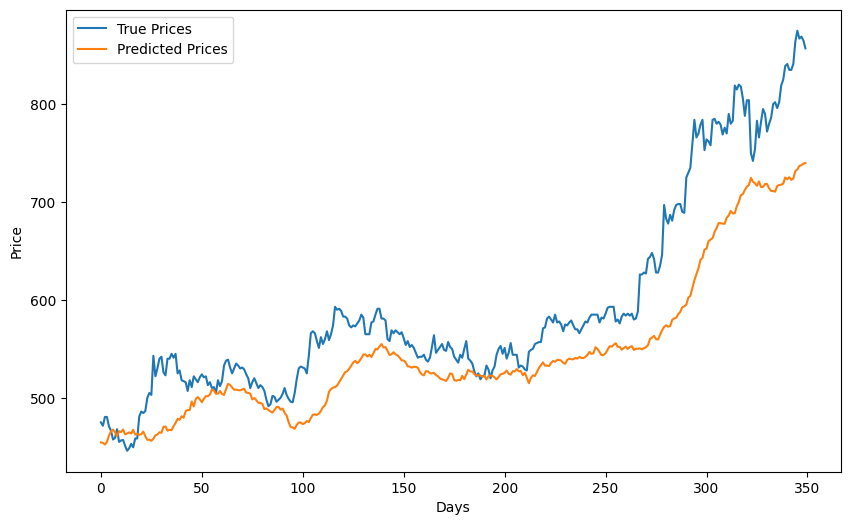

In [38]:
# 使用微調後的模型進行預測
predicted_stock_prices = fine_tune_model.predict(x_stock_test)

# 反標準化預測值
def inverse_transform(scaler, data, original_shape):
    result = []
    for i in range(len(data)):
        scaled_data = np.concatenate([np.zeros((1, original_shape - 1)), data[i].reshape(1, -1)], axis=1)
        result.append(scaler.inverse_transform(scaled_data)[0, -1])
    return np.array(result)

predicted_stock_prices = inverse_transform(scaler, predicted_stock_prices, original_shape=x_stock.shape[2])
y_stock_test_true = inverse_transform(scaler, y_stock_test.reshape(-1, 1), original_shape=x_stock.shape[2])

# 計算微調後的RMSE
fine_tune_rmse = math.sqrt(mean_squared_error(y_stock_test_true, predicted_stock_prices))

print(f"Fine-tuned RMSE: {fine_tune_rmse}")

# 畫出預測結果
plt.figure(figsize=(10, 6))
plt.plot(y_stock_test_true, label='True Prices')
plt.plot(predicted_stock_prices, label='Predicted Prices')
plt.xlabel('Days')
plt.ylabel('Price')
plt.legend()
plt.show()


In [12]:
fine_tune_history = fine_tune_model.fit(x_stock_train, y_stock_train,
                    batch_size=64,
                    epochs=200,
                    validation_data=(x_stock_val, y_stock_val),
                    callbacks=[EarlyStopping(patience=30, restore_best_weights=True)])

Epoch 1/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 3.3212e-04 - val_loss: 0.0045
Epoch 2/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 2.5436e-04 - val_loss: 0.0038
Epoch 3/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 2.7481e-04 - val_loss: 0.0028
Epoch 4/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 2.7023e-04 - val_loss: 0.0033
Epoch 5/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 2.5006e-04 - val_loss: 0.0033
Epoch 6/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 2.1210e-04 - val_loss: 0.0036
Epoch 7/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 2.4459e-04 - val_loss: 0.0039
Epoch 8/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 2.5881e-04 - val_loss: 0.0029
Epoch 9/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 2.8761e-04 - val_loss: 0.0027
Epoch 10/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 2.3009e-04 - val_loss: 0.0041
Epoch 11/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 2.1748e-04 - val_loss: 0.0039
Epoch 12/200

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Fine-tuned RMSE: 72.31377467858537


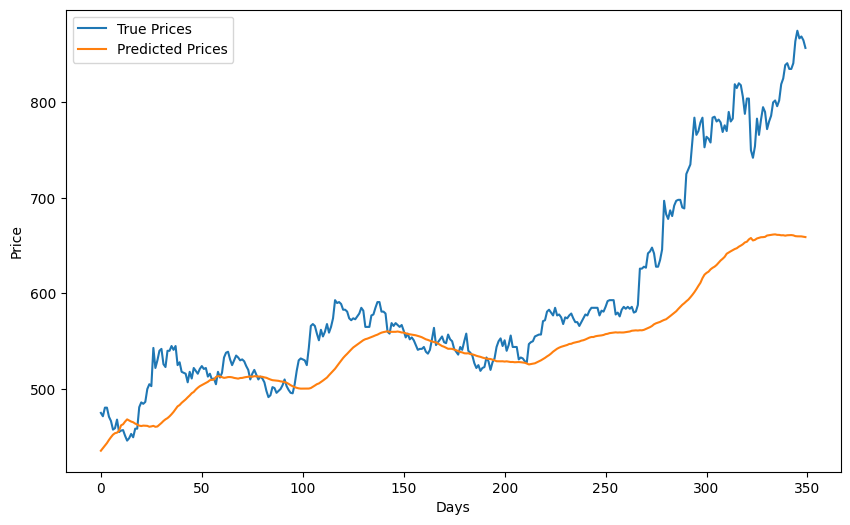

In [13]:
# 使用微調後的模型進行預測
predicted_stock_prices = fine_tune_model.predict(x_stock_test)

# 反標準化預測值
def inverse_transform(scaler, data, original_shape):
    result = []
    for i in range(len(data)):
        scaled_data = np.concatenate([np.zeros((1, original_shape - 1)), data[i].reshape(1, -1)], axis=1)
        result.append(scaler.inverse_transform(scaled_data)[0, -1])
    return np.array(result)

predicted_stock_prices = inverse_transform(scaler, predicted_stock_prices, original_shape=x_stock.shape[2])
y_stock_test_true = inverse_transform(scaler, y_stock_test.reshape(-1, 1), original_shape=x_stock.shape[2])

# 計算微調後的RMSE
fine_tune_rmse = math.sqrt(mean_squared_error(y_stock_test_true, predicted_stock_prices))

print(f"Fine-tuned RMSE: {fine_tune_rmse}")

# 畫出預測結果
plt.figure(figsize=(10, 6))
plt.plot(y_stock_test_true, label='True Prices')
plt.plot(predicted_stock_prices, label='Predicted Prices')
plt.xlabel('Days')
plt.ylabel('Price')
plt.legend()
plt.show()